## 1 - Importanto as bibliotecas

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import statsmodels.api as sm
import scipy.stats
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from yellowbrick.regressor import ResidualsPlot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings('ignore')

## 2 - Lendo o Arquivo

In [2]:
data = pd.read_csv('data/consumo_cerveja.csv')


### 2.1 - Verificando o dataset

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 941 entries, 0 to 940
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Data                         365 non-null    object 
 1   Temperatura Media (C)        365 non-null    object 
 2   Temperatura Minima (C)       365 non-null    object 
 3   Temperatura Maxima (C)       365 non-null    object 
 4   Precipitacao (mm)            365 non-null    object 
 5   Final de Semana              365 non-null    float64
 6   Consumo de cerveja (litros)  365 non-null    float64
dtypes: float64(2), object(5)
memory usage: 51.6+ KB


In [4]:
# mostrando o shape do dataframe, linhas e colunas
data.shape

(941, 7)

In [5]:
# mostrando as primeiras linhas do dataframe
data.head()

,Data,Temperatura Media (C),Temperatura Minima (C),Temperatura Maxima (C),Precipitacao (mm),Final de Semana,Consumo de cerveja (litros)
0,2015-01-01,"27,3","23,9","32,5",0,0.0,25.461
1,2015-01-02,"27,02","24,5","33,5",0,0.0,28.972
2,2015-01-03,"24,82","22,4","29,9",0,1.0,30.814
3,2015-01-04,"23,98","21,5","28,6","1,2",1.0,29.799
4,2015-01-05,"23,82",21,"28,3",0,0.0,28.900


In [6]:
# mostrando as primeiras linhas do dataframe
data.tail()

,Data,Temperatura Media (C),Temperatura Minima (C),Temperatura Maxima (C),Precipitacao (mm),Final de Semana,Consumo de cerveja (litros)
936,NaN,NaN,NaN,NaN,NaN,NaN,NaN
937,NaN,NaN,NaN,NaN,NaN,NaN,NaN
938,NaN,NaN,NaN,NaN,NaN,NaN,NaN
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3 - Limpeza de dados

### 3.1 - Linhas duplicada, colunas duplicadas e colunas constantes e valores nulos

####  3.1.1 Valores Nulos

In [7]:
def checa_nulos(df):
    '''
    recebe um dataframe e retorna a porcentagem de nulos em cada uma das colunas
    '''
    # Checando colunas com nulos
    coluna_nulos = pd.Series(df.isnull().sum(), name='nulos')

    coluna_nulosperc = pd.Series(100 * (df.isnull().sum()/ df.shape[0]), name='%')

    df_nulos = pd.merge(coluna_nulos, coluna_nulosperc, right_index = True,
                left_index = True).round(2)
    return df_nulos

In [8]:
checa_nulos(data)

,nulos,%
Data,576,61.21
Temperatura Media (C),576,61.21
Temperatura Minima (C),576,61.21
Temperatura Maxima (C),576,61.21
Precipitacao (mm),576,61.21
Final de Semana,576,61.21
Consumo de cerveja (litros),576,61.21


In [9]:
data.dropna(inplace=True)

#### 3.1.2 convertendo colunas

In [10]:
# Final de semana de float para inteiro
data['Final de Semana'] = data['Final de Semana'].astype(int)

# Transformação das colunas de object para float
data['Temperatura Media (C)'] = data['Temperatura Media (C)'].str.replace(',', '.').astype('float64')
data['Temperatura Minima (C)'] = data['Temperatura Minima (C)'].str.replace(',', '.').astype('float64')
data['Temperatura Maxima (C)'] = data['Temperatura Maxima (C)'].str.replace(',', '.').astype('float64')
data['Precipitacao (mm)'] = data['Precipitacao (mm)'].str.replace(',', '.').astype('float64')

# Data de string para datetime
data['Data'] = pd.to_datetime(data['Data'])

data

,Data,Temperatura Media (C),Temperatura Minima (C),Temperatura Maxima (C),Precipitacao (mm),Final de Semana,Consumo de cerveja (litros)
0,2015-01-01,27.30,23.9,32.5,0.0,0,25.461
1,2015-01-02,27.02,24.5,33.5,0.0,0,28.972
2,2015-01-03,24.82,22.4,29.9,0.0,1,30.814
3,2015-01-04,23.98,21.5,28.6,1.2,1,29.799
4,2015-01-05,23.82,21.0,28.3,0.0,0,28.900
...,...,...,...,...,...,...,...
360,2015-12-27,24.00,21.1,28.2,13.6,1,32.307
361,2015-12-28,22.64,21.1,26.7,0.0,0,26.095
362,2015-12-29,21.68,20.3,24.1,10.3,0,22.309
363,2015-12-30,21.38,19.3,22.4,6.3,0,20.467


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 0 to 364
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Data                         365 non-null    datetime64[ns]
 1   Temperatura Media (C)        365 non-null    float64       
 2   Temperatura Minima (C)       365 non-null    float64       
 3   Temperatura Maxima (C)       365 non-null    float64       
 4   Precipitacao (mm)            365 non-null    float64       
 5   Final de Semana              365 non-null    int32         
 6   Consumo de cerveja (litros)  365 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int32(1)
memory usage: 21.4 KB


#### 3.1.2 Linhas duplicadas

In [12]:
def linhas_duplicadas(df):
    '''
    recebe um df e retorna a quandidade de linhas duplicadas
    '''
    # Linhas duplicadas
    if df.shape[0] != df.drop_duplicates().shape[0]:
        n_linhas_duplicadas = df.shape[0] - df.drop_duplicates().shape[0]
        print(f'Existem {n_linhas_duplicadas} linhas duplicadas')
    else:
        print('Não há linhas duplicadas no conjunto de dados.')
    return None

In [13]:
linhas_duplicadas(data)

Não há linhas duplicadas no conjunto de dados.


In [14]:
# data = data.drop_duplicates()

#### 3.1.3 Colunas duplicadas

In [15]:
def colunas_duplicadas(df):
    '''
    recebe um df e retorna a quandidade de colunas duplicadas
    '''
    # Colunas duplicadas
    colunas_duplicadas = []
    for col1 in df.columns.tolist():
        for col2 in df.columns.tolist():
            if col1 != col2:
                if (df[col1] == df[col2]).all():
                    colunas_duplicadas.append([col1, col2])

    if len(colunas_duplicadas) > 0:
        print('Colunas duplicadas:', colunas_duplicadas)
    else:
        print('Não há colunas duplicadas no conjunto de dados.')
    return None

In [16]:
colunas_duplicadas(data)

Não há colunas duplicadas no conjunto de dados.


#### 3.1.4 Colunas com constantes

In [17]:
def colunas_constantes(df):
    '''
    recebe um dataframe e dropa as colunas que são constantes
    '''
    # Colunas constantes
    colunas_constantes = []
    for col in df.columns.tolist():
        if df[col].nunique() == 1:
            colunas_constantes.append(col)

    if len(colunas_constantes) > 0:
        print('Colunas constantes:', colunas_constantes)
        df.drop(colunas_constantes, axis=1, inplace=True)
    else:
        print('Não há colunas constantes no conjunto de dados.')
    return None

In [18]:
colunas_constantes(data)

Não há colunas constantes no conjunto de dados.


#### 3.1.5 Colunas com baixa variancia

In [19]:
def identify_cols_low_variance(df, low_variance_threshold):
    '''
    recebe um df
    retorna uma lista de colunas com baixa variancia
    -
    df - > dataframe a ser analisado
    low_variance_threshold -> 0.001 (indicado)
    '''
    # Inicializa scaler
    scaler = MinMaxScaler()
    # Seleciona apenas variáveis numéricas
    df_numericas = df.select_dtypes(exclude=['object', 'datetime64[ns]'])
    # Faz scaling das variáveis
    df_scaled = pd.DataFrame(
        scaler.fit_transform(df_numericas),
        columns=df_numericas.columns
    )
    
    colunas_baixa_variancia = []
    for col in df_scaled.columns:
        if df_scaled[col].var() < low_variance_threshold:
            colunas_baixa_variancia.append(col)
            
    return colunas_baixa_variancia

In [20]:
colunas_baixa_variancia = identify_cols_low_variance(data, low_variance_threshold=0.001)

if len(colunas_baixa_variancia) > 0:
    print('Colunas com baixa variância:', colunas_baixa_variancia)
    data.drop(colunas_baixa_variancia, axis=1, inplace=True)
else:
    print('Não há colunas com baixa variância no conjunto de dados.')

Não há colunas com baixa variância no conjunto de dados.


## 4 - Criando novas variaveis

In [21]:
feriados = pd.read_csv('data/2015_feriados_SP.csv', sep=',', encoding='latin1')


In [22]:
feriados['Dia'] = pd.to_datetime(feriados['Dia'])
feriados

,Dia,Feriado
0,2015-01-01,Ano Novo
1,2015-01-25,Aniversario da Cidade
2,2015-02-16,Carnaval
3,2015-02-17,Carnaval
4,2015-02-18,Carnaval
5,2015-04-03,Sexta-Feira Santa
6,2015-04-03,Sexta-feira Santa
7,2015-04-21,Dia de Tiradentes
8,2015-05-01,Dia do Trabalho
9,2015-06-04,Corpus Christi


In [23]:
meses = {1:'Janeiro',2:'Fevereiro',3:'Março',4:'Abril',5:'Maio',6:'Junho',7:'Julho',8:'Agosto',9:'Setembro',
                           10:'Outubro',11:'Novembro',12:'Dezembro'}

dias_da_semana = {0:'Seg',1:'Ter',2:'Qua',3:'Qui',4:'Sex',5:'Sab',6:'Dom'}

# Criação da coluna do mês
data['Mes'] = data['Data'].dt.month
data['Mes'] = data['Mes'].map(meses)

# Criação da coluna de dia da semana
data['Dia da Semana'] = data['Data'].dt.dayofweek
data['Dia da Semana'] = data['Dia da Semana'].map(dias_da_semana)

# Identificação das observações que foram em feriados
data['Feriado'] = [dia in list(feriados['Dia']) for dia in data['Data']]

# Definição de dia útil ou não
data['Dia util'] = ~(data['Final de Semana'] | data['Feriado'])

In [24]:
data

,Data,Temperatura Media (C),Temperatura Minima (C),Temperatura Maxima (C),Precipitacao (mm),Final de Semana,Consumo de cerveja (litros),Mes,Dia da Semana,Feriado,Dia util
0,2015-01-01,27.30,23.9,32.5,0.0,0,25.461,Janeiro,Qui,True,False
1,2015-01-02,27.02,24.5,33.5,0.0,0,28.972,Janeiro,Sex,False,True
2,2015-01-03,24.82,22.4,29.9,0.0,1,30.814,Janeiro,Sab,False,False
3,2015-01-04,23.98,21.5,28.6,1.2,1,29.799,Janeiro,Dom,False,False
4,2015-01-05,23.82,21.0,28.3,0.0,0,28.900,Janeiro,Seg,False,True
...,...,...,...,...,...,...,...,...,...,...,...
360,2015-12-27,24.00,21.1,28.2,13.6,1,32.307,Dezembro,Dom,False,False
361,2015-12-28,22.64,21.1,26.7,0.0,0,26.095,Dezembro,Seg,False,True
362,2015-12-29,21.68,20.3,24.1,10.3,0,22.309,Dezembro,Ter,False,True
363,2015-12-30,21.38,19.3,22.4,6.3,0,20.467,Dezembro,Qua,False,True


In [25]:
semana = {0:'Dia de semana', 1:'Final de semana'}
feriado = {0:'Não é feriado', 1:'Feriado'}
dia_util = {0:'Não é dia util', 1:'Dia util'}

# Trocando a colula final de semana de valores inteiros para strings
data['Final de Semana'] = data['Final de Semana'].apply(lambda x:semana[x])

# Trocando a colula feriado de valores inteiros para strings
data['Feriado'] = data['Feriado'].apply(lambda y:feriado[y])

# Trocando a colula dia util de valores inteiros para strings
data['Dia util'] = data['Dia util'].apply(lambda z:dia_util[z])

data.head(5)

,Data,Temperatura Media (C),Temperatura Minima (C),Temperatura Maxima (C),Precipitacao (mm),Final de Semana,Consumo de cerveja (litros),Mes,Dia da Semana,Feriado,Dia util
0,2015-01-01,27.30,23.9,32.5,0.0,Dia de semana,25.461,Janeiro,Qui,Feriado,Não é dia util
1,2015-01-02,27.02,24.5,33.5,0.0,Dia de semana,28.972,Janeiro,Sex,Não é feriado,Dia util
2,2015-01-03,24.82,22.4,29.9,0.0,Final de semana,30.814,Janeiro,Sab,Não é feriado,Não é dia util
3,2015-01-04,23.98,21.5,28.6,1.2,Final de semana,29.799,Janeiro,Dom,Não é feriado,Não é dia util
4,2015-01-05,23.82,21.0,28.3,0.0,Dia de semana,28.900,Janeiro,Seg,Não é feriado,Dia util


## 5 - Estatística do dataset

#### 5.1 Estatística básica

In [26]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperatura Media (C),365.0,21.226356,3.180108,12.900,19.020,21.380,23.280,28.860
Temperatura Minima (C),365.0,17.461370,2.826185,10.600,15.300,17.900,19.600,24.500
Temperatura Maxima (C),365.0,26.611507,4.317366,14.500,23.800,26.900,29.400,36.500
Precipitacao (mm),365.0,5.196712,12.417844,0.000,0.000,0.000,3.200,94.800
Consumo de cerveja (litros),365.0,25.401367,4.399143,14.343,22.008,24.867,28.631,37.937


#### 5.2 - Verificando Outliers

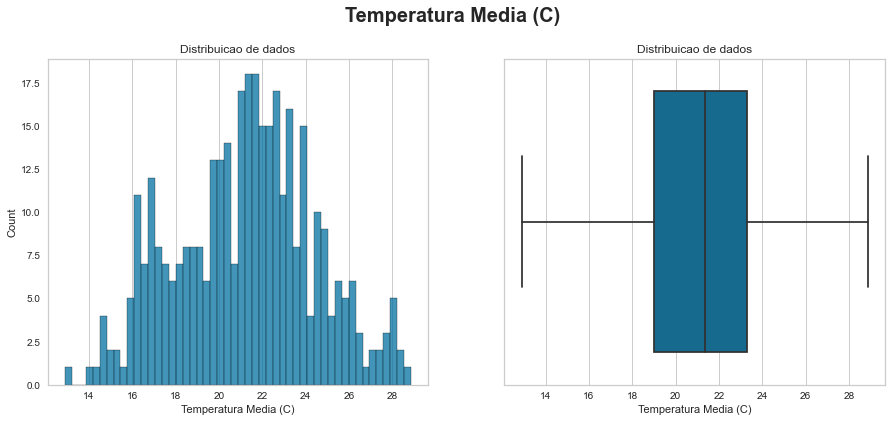

In [27]:
fig, ax = plt.subplots (1,2, figsize = (15,6))
ax[0].set_title(f'Distribuicao de dados')
ax[1].set_title(f'Distribuicao de dados')

fig.suptitle (f'Temperatura Media (C)', fontsize = 20, fontweight = 'bold', y =1)
sns.histplot(data = data['Temperatura Media (C)'],bins = 50, ax=ax[0])
ax[0].grid(axis = 'y')


ax = sns.boxplot(x=data['Temperatura Media (C)'], ax=ax[1])
# ax[1].set_title(f'Distribuicao de dados')
plt.show()

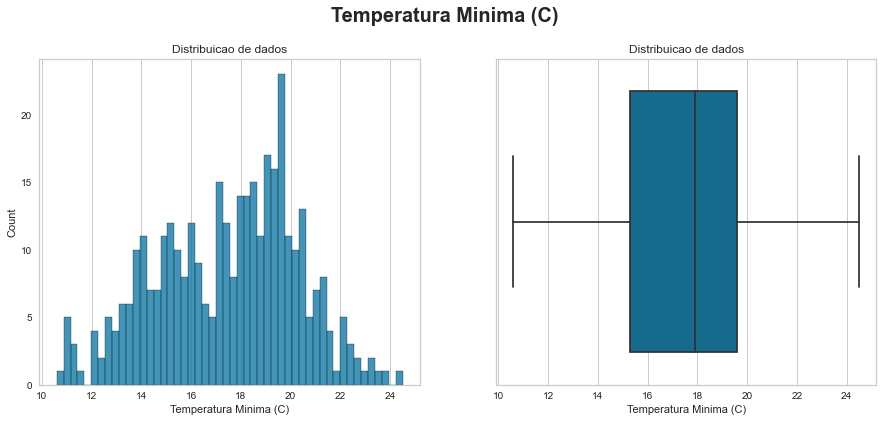

In [28]:
fig, ax = plt.subplots (1,2, figsize = (15,6))
ax[0].set_title(f'Distribuicao de dados')
ax[1].set_title(f'Distribuicao de dados')

fig.suptitle (f'Temperatura Minima (C)', fontsize = 20, fontweight = 'bold', y =1)
sns.histplot(data = data['Temperatura Minima (C)'],bins = 50, ax=ax[0])
ax[0].grid(axis = 'y')


ax = sns.boxplot(x=data['Temperatura Minima (C)'], ax=ax[1])
# ax[1].set_title(f'Distribuicao de dados')
plt.show()

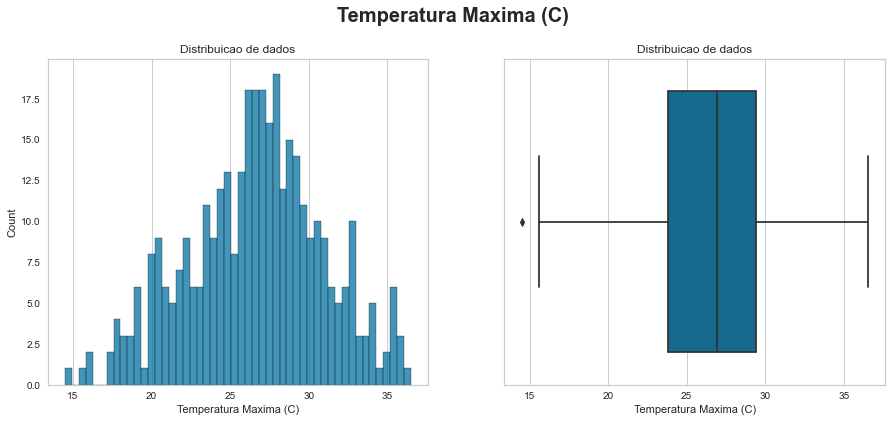

In [29]:
fig, ax = plt.subplots (1,2, figsize = (15,6))
ax[0].set_title(f'Distribuicao de dados')
ax[1].set_title(f'Distribuicao de dados')

fig.suptitle (f'Temperatura Maxima (C)', fontsize = 20, fontweight = 'bold', y =1)
sns.histplot(data = data['Temperatura Maxima (C)'],bins = 50, ax=ax[0])
ax[0].grid(axis = 'y')


ax = sns.boxplot(x=data['Temperatura Maxima (C)'], ax=ax[1])
# ax[1].set_title(f'Distribuicao de dados')
plt.show()

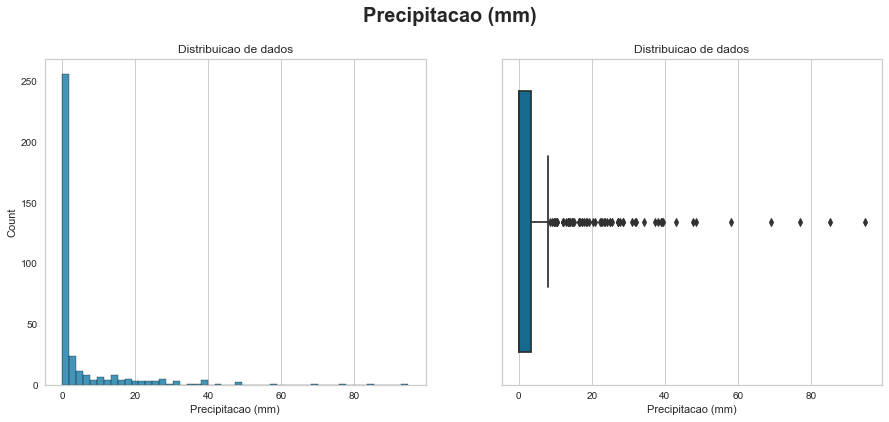

In [30]:
fig, ax = plt.subplots (1,2, figsize = (15,6))
ax[0].set_title(f'Distribuicao de dados')
ax[1].set_title(f'Distribuicao de dados')

fig.suptitle (f'Precipitacao (mm)', fontsize = 20, fontweight = 'bold', y =1)
sns.histplot(data = data['Precipitacao (mm)'],bins = 50, ax=ax[0])
ax[0].grid(axis = 'y')


ax = sns.boxplot(x=data['Precipitacao (mm)'], ax=ax[1])
# ax[1].set_title(f'Distribuicao de dados')
plt.show()

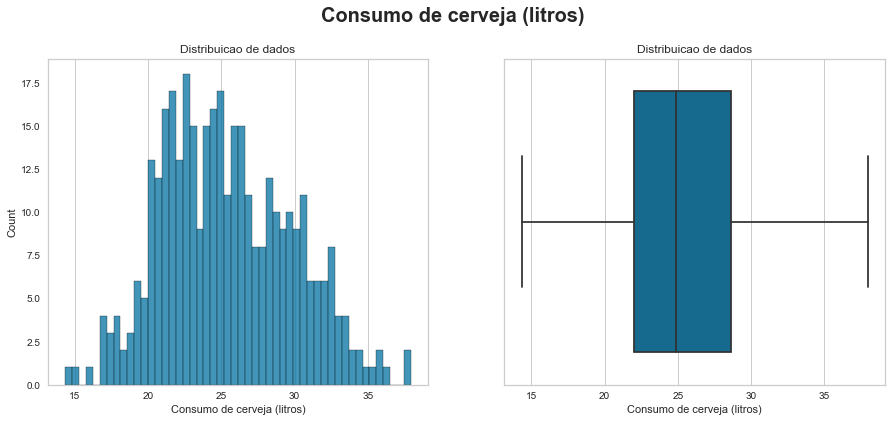

In [31]:
fig, ax = plt.subplots (1,2, figsize = (15,6))
ax[0].set_title(f'Distribuicao de dados')
ax[1].set_title(f'Distribuicao de dados')

fig.suptitle (f'Consumo de cerveja (litros)', fontsize = 20, fontweight = 'bold', y =1)
sns.histplot(data = data['Consumo de cerveja (litros)'],bins = 50, ax=ax[0])
ax[0].grid(axis = 'y')


ax = sns.boxplot(x=data['Consumo de cerveja (litros)'], ax=ax[1])
# ax[1].set_title(f'Distribuicao de dados')
plt.show()

#### 5.3 Verificando a correlação

In [32]:
corr = data.corr()
corr

,Temperatura Media (C),Temperatura Minima (C),Temperatura Maxima (C),Precipitacao (mm),Consumo de cerveja (litros)
Temperatura Media (C),1.000000,0.862752,0.922513,0.024416,0.574615
Temperatura Minima (C),0.862752,1.000000,0.672929,0.098625,0.392509
Temperatura Maxima (C),0.922513,0.672929,1.000000,-0.049305,0.642672
Precipitacao (mm),0.024416,0.098625,-0.049305,1.000000,-0.193784
Consumo de cerveja (litros),0.574615,0.392509,0.642672,-0.193784,1.000000


<AxesSubplot:>

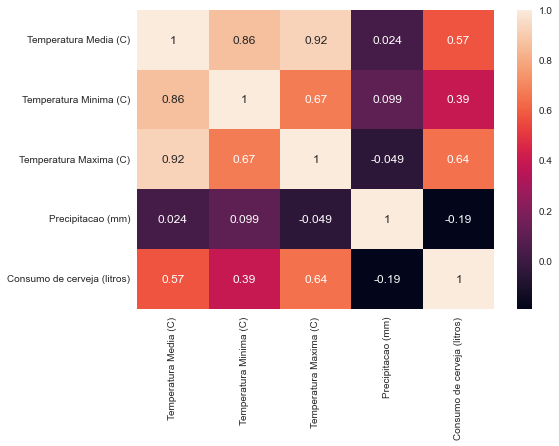

In [33]:
sns.heatmap(corr, annot=True)

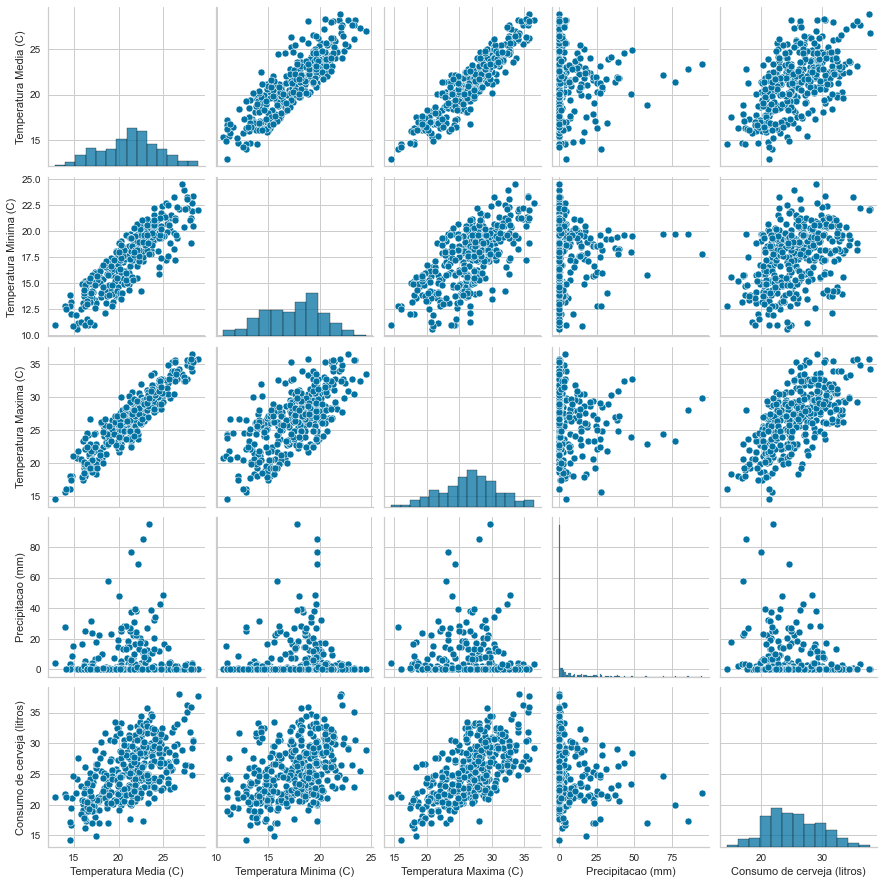

In [34]:
sns.pairplot(data)
plt.show()

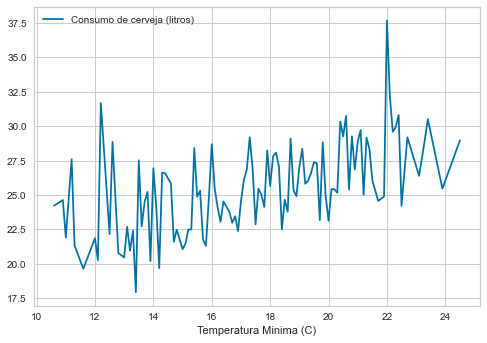

In [35]:
# H1: consumo em dias frios
data.pivot_table(values='Consumo de cerveja (litros)', columns='Temperatura Minima (C)',aggfunc='mean').T.plot()
plt.show()

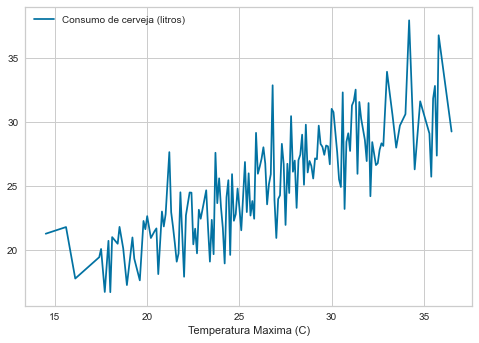

In [36]:
# H2: consumo em dias quentes
data.pivot_table(values='Consumo de cerveja (litros)', columns='Temperatura Maxima (C)',aggfunc='mean').T.plot()
plt.show()

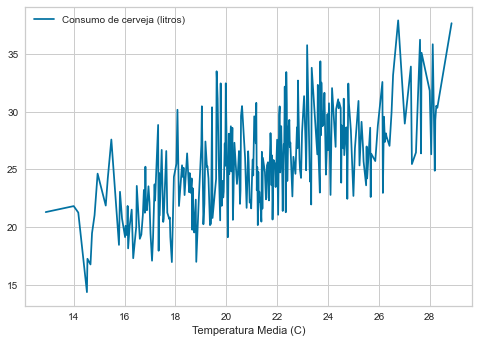

In [37]:
# H2: consumo em dias com temperatura média
data.pivot_table(values='Consumo de cerveja (litros)', columns='Temperatura Media (C)',aggfunc='mean').T.plot()
plt.show()

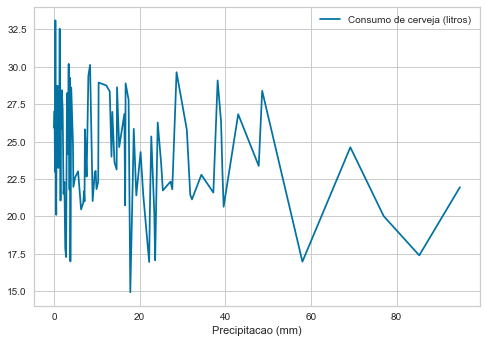

In [38]:
# H2: consumo em dias chuvosos
data.pivot_table(values='Consumo de cerveja (litros)', columns='Precipitacao (mm)',aggfunc='mean').T.plot()
plt.show()

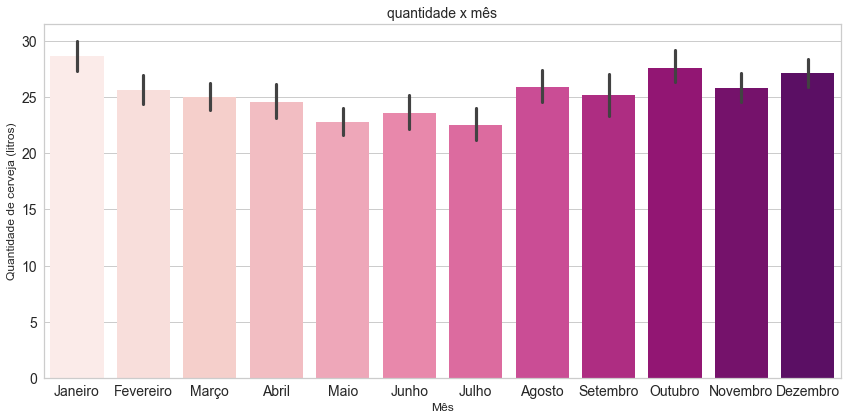

In [39]:
#criando uma figure, axes, alterando tamanho
fig, ax = plt.subplots(figsize=(12,6))
#criando o gráfico de barras
sns.barplot(x=data['Mes'], y=data['Consumo de cerveja (litros)'], ax=ax, data=data,     
            palette='RdPu')
#adicionando título
ax.set_title("quantidade x mês", fontdict={'fontsize':14})
#mudando nome e tamanho do label x
ax.set_xlabel('Mês', fontdict={'fontsize':12})
#mudando nome e tamanho do label y
ax.set_ylabel('Quantidade de cerveja (litros)', fontdict={'fontsize':12})
#mudando tamanho dos labels dos ticks
ax.tick_params(labelsize=14)
#otimizar espaço da figure
fig.tight_layout();

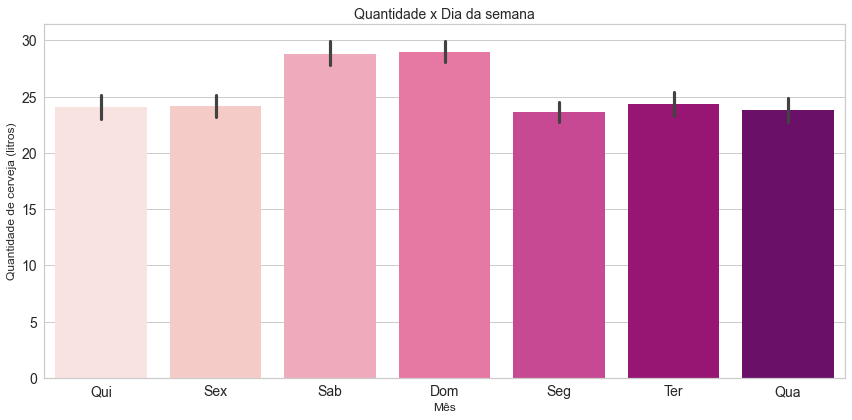

In [40]:
#criando uma figure, axes, alterando tamanho
fig, ax = plt.subplots(figsize=(12,6))
#criando o gráfico de barras
sns.barplot(x=data['Dia da Semana'], y=data['Consumo de cerveja (litros)'], ax=ax, data=data,     
            palette='RdPu')
#adicionando título
ax.set_title("Quantidade x Dia da semana", fontdict={'fontsize':14})
#mudando nome e tamanho do label x
ax.set_xlabel('Mês', fontdict={'fontsize':12})
#mudando nome e tamanho do label y
ax.set_ylabel('Quantidade de cerveja (litros)', fontdict={'fontsize':12})
#mudando tamanho dos labels dos ticks
ax.tick_params(labelsize=14)
#otimizar espaço da figure
fig.tight_layout();

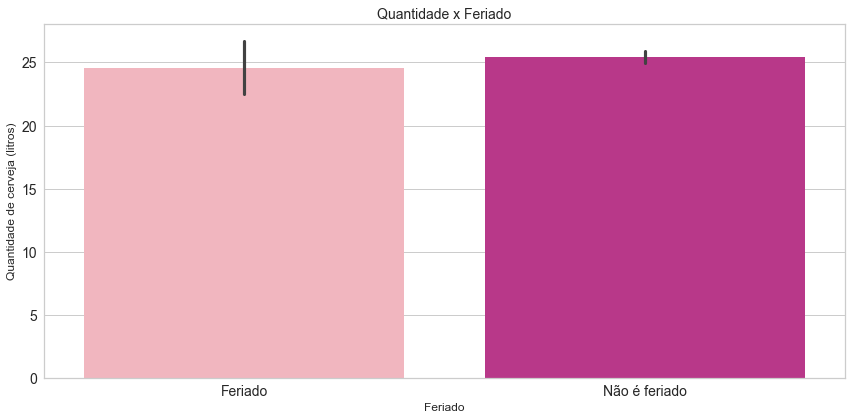

In [41]:
#criando uma figure, axes, alterando tamanho
fig, ax = plt.subplots(figsize=(12,6))
#criando o gráfico de barras
sns.barplot(x=data['Feriado'], y=data['Consumo de cerveja (litros)'], ax=ax, data=data,     
            palette='RdPu')
#adicionando título
ax.set_title("Quantidade x Feriado", fontdict={'fontsize':14})
#mudando nome e tamanho do label x
ax.set_xlabel('Feriado', fontdict={'fontsize':12})
#mudando nome e tamanho do label y
ax.set_ylabel('Quantidade de cerveja (litros)', fontdict={'fontsize':12})
#mudando tamanho dos labels dos ticks
ax.tick_params(labelsize=14)
#otimizar espaço da figure
fig.tight_layout();

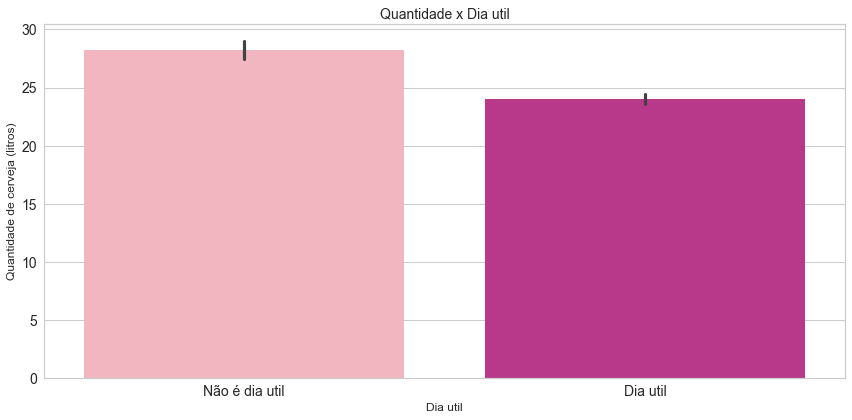

In [42]:
#criando uma figure, axes, alterando tamanho
fig, ax = plt.subplots(figsize=(12,6))
#criando o gráfico de barras
sns.barplot(x=data['Dia util'], y=data['Consumo de cerveja (litros)'], ax=ax, data=data,     
            palette='RdPu')
#adicionando título
ax.set_title("Quantidade x Dia util", fontdict={'fontsize':14})
#mudando nome e tamanho do label x
ax.set_xlabel('Dia util', fontdict={'fontsize':12})
#mudando nome e tamanho do label y
ax.set_ylabel('Quantidade de cerveja (litros)', fontdict={'fontsize':12})
#mudando tamanho dos labels dos ticks
ax.tick_params(labelsize=14)
#otimizar espaço da figure
fig.tight_layout();

## 6 - Modelagem

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 0 to 364
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Data                         365 non-null    datetime64[ns]
 1   Temperatura Media (C)        365 non-null    float64       
 2   Temperatura Minima (C)       365 non-null    float64       
 3   Temperatura Maxima (C)       365 non-null    float64       
 4   Precipitacao (mm)            365 non-null    float64       
 5   Final de Semana              365 non-null    object        
 6   Consumo de cerveja (litros)  365 non-null    float64       
 7   Mes                          365 non-null    object        
 8   Dia da Semana                365 non-null    object        
 9   Feriado                      365 non-null    object        
 10  Dia util                     365 non-null    object        
dtypes: datetime64[ns](1), float64(5), object(5)
m

In [44]:
data

,Data,Temperatura Media (C),Temperatura Minima (C),Temperatura Maxima (C),Precipitacao (mm),Final de Semana,Consumo de cerveja (litros),Mes,Dia da Semana,Feriado,Dia util
0,2015-01-01,27.30,23.9,32.5,0.0,Dia de semana,25.461,Janeiro,Qui,Feriado,Não é dia util
1,2015-01-02,27.02,24.5,33.5,0.0,Dia de semana,28.972,Janeiro,Sex,Não é feriado,Dia util
2,2015-01-03,24.82,22.4,29.9,0.0,Final de semana,30.814,Janeiro,Sab,Não é feriado,Não é dia util
3,2015-01-04,23.98,21.5,28.6,1.2,Final de semana,29.799,Janeiro,Dom,Não é feriado,Não é dia util
4,2015-01-05,23.82,21.0,28.3,0.0,Dia de semana,28.900,Janeiro,Seg,Não é feriado,Dia util
...,...,...,...,...,...,...,...,...,...,...,...
360,2015-12-27,24.00,21.1,28.2,13.6,Final de semana,32.307,Dezembro,Dom,Não é feriado,Não é dia util
361,2015-12-28,22.64,21.1,26.7,0.0,Dia de semana,26.095,Dezembro,Seg,Não é feriado,Dia util
362,2015-12-29,21.68,20.3,24.1,10.3,Dia de semana,22.309,Dezembro,Ter,Não é feriado,Dia util
363,2015-12-30,21.38,19.3,22.4,6.3,Dia de semana,20.467,Dezembro,Qua,Não é feriado,Dia util


In [45]:
data

,Data,Temperatura Media (C),Temperatura Minima (C),Temperatura Maxima (C),Precipitacao (mm),Final de Semana,Consumo de cerveja (litros),Mes,Dia da Semana,Feriado,Dia util
0,2015-01-01,27.30,23.9,32.5,0.0,Dia de semana,25.461,Janeiro,Qui,Feriado,Não é dia util
1,2015-01-02,27.02,24.5,33.5,0.0,Dia de semana,28.972,Janeiro,Sex,Não é feriado,Dia util
2,2015-01-03,24.82,22.4,29.9,0.0,Final de semana,30.814,Janeiro,Sab,Não é feriado,Não é dia util
3,2015-01-04,23.98,21.5,28.6,1.2,Final de semana,29.799,Janeiro,Dom,Não é feriado,Não é dia util
4,2015-01-05,23.82,21.0,28.3,0.0,Dia de semana,28.900,Janeiro,Seg,Não é feriado,Dia util
...,...,...,...,...,...,...,...,...,...,...,...
360,2015-12-27,24.00,21.1,28.2,13.6,Final de semana,32.307,Dezembro,Dom,Não é feriado,Não é dia util
361,2015-12-28,22.64,21.1,26.7,0.0,Dia de semana,26.095,Dezembro,Seg,Não é feriado,Dia util
362,2015-12-29,21.68,20.3,24.1,10.3,Dia de semana,22.309,Dezembro,Ter,Não é feriado,Dia util
363,2015-12-30,21.38,19.3,22.4,6.3,Dia de semana,20.467,Dezembro,Qua,Não é feriado,Dia util


In [46]:
df_onehot = pd.get_dummies(data)
df_onehot.head()

,Data,Temperatura Media (C),Temperatura Minima (C),Temperatura Maxima (C),Precipitacao (mm),Consumo de cerveja (litros),Final de Semana_Dia de semana,Final de Semana_Final de semana,Mes_Abril,Mes_Agosto,...,Dia da Semana_Qua,Dia da Semana_Qui,Dia da Semana_Sab,Dia da Semana_Seg,Dia da Semana_Sex,Dia da Semana_Ter,Feriado_Feriado,Feriado_Não é feriado,Dia util_Dia util,Dia util_Não é dia util
0,2015-01-01,27.30,23.9,32.5,0.0,25.461,1,0,0,0,...,0,1,0,0,0,0,1,0,0,1
1,2015-01-02,27.02,24.5,33.5,0.0,28.972,1,0,0,0,...,0,0,0,0,1,0,0,1,1,0
2,2015-01-03,24.82,22.4,29.9,0.0,30.814,0,1,0,0,...,0,0,1,0,0,0,0,1,0,1
3,2015-01-04,23.98,21.5,28.6,1.2,29.799,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
4,2015-01-05,23.82,21.0,28.3,0.0,28.900,1,0,0,0,...,0,0,0,1,0,0,0,1,1,0


In [47]:
data_2 = df_onehot.drop('Data', axis=1)

In [48]:
# Dividindo em X e Y
X = data_2.drop('Consumo de cerveja (litros)', axis = 1)
y = data_2['Consumo de cerveja (litros)']# Dividindo em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size = 0.70, 
                                                    random_state = 123)

X_train.shape,X_test.shape,y_train.shape,y_test.shape

((255, 29), (110, 29), (255,), (110,))

In [49]:
# Regressão Linear
lr_regressor = LinearRegression()
lr_regressor.fit(X_train, y_train)

# Predição do conjunto de teste
y_pred = lr_regressor.predict(X_test)
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
r2 = metrics.r2_score(y_test, y_pred)

results = pd.DataFrame([['Multiple Linear Regression', mae, mse, rmse, r2]],
               columns = ['Model', 'MAE', 'MSE', 'RMSE', 'R2 Score'])

In [50]:
print('Intercepto:', lr_regressor.intercept_)

Intercepto: 7.1480402554189375


In [51]:
coeff_df = pd.DataFrame(lr_regressor.coef_,X.columns,columns=['Coefficient'])
coeff_df.sort_values(by='Coefficient', ascending=False)

,Coefficient
Mes_Outubro,1.695664
Dia util_Não é dia util,1.401266
Feriado_Não é feriado,1.177356
Final de Semana_Final de semana,0.910737
Temperatura Maxima (C),0.699338
Mes_Dezembro,0.686230
Mes_Agosto,0.684661
Mes_Junho,0.590841
Mes_Novembro,0.546752
Dia da Semana_Dom,0.511170


In [52]:
# Random Forest
rf_regressor = RandomForestRegressor(n_estimators=300, random_state=0)
rf_regressor.fit(X_train,y_train)

# Predição do conjunto de teste
y_pred = rf_regressor.predict(X_test)
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
r2 = metrics.r2_score(y_test, y_pred)

model_results = pd.DataFrame([['Random Forest Regression', mae, mse, rmse, r2]],
               columns = ['Model', 'MAE', 'MSE', 'RMSE', 'R2 Score'])

results = results.append(model_results, ignore_index = True)

In [53]:
# Decision Tree Regression
dt_regressor = DecisionTreeRegressor(random_state=0)
dt_regressor.fit(X_train, y_train)

# Predição do conjunto de teste
y_pred = dt_regressor.predict(X_test)

mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
r2 = metrics.r2_score(y_test, y_pred)

model_results = pd.DataFrame([['Decision Tree Regression', mae, mse, rmse, r2]],
               columns = ['Model', 'MAE', 'MSE', 'RMSE', 'R2 Score'])

results = results.append(model_results, ignore_index = True)

In [54]:
results.sort_values(by='R2 Score', ascending=False)

,Model,MAE,MSE,RMSE,R2 Score
0,Multiple Linear Regression,2.065920,6.111579,2.472161,0.676620
1,Random Forest Regression,2.192662,6.882260,2.623406,0.635842
2,Decision Tree Regression,2.876791,14.103944,3.755522,0.253723


In [55]:
parameters = {'n_estimators': range(10,200,10), 'max_depth': range(10,100,5)}
rf = RandomForestRegressor()
gs_rf = GridSearchCV(rf, parameters)
gs_rf.fit(X_train, y_train)
gs_rf.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=70, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

RandomForestRegressor(criterion='mse', max_depth=70, max_features='auto',
                      n_estimators=30)

In [56]:
gs_rf.best_score_

0.6377569297447886